In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
from matplotlib import rc,rcParams
from aacgmv2 import convert
from scipy.interpolate import interp1d 
rc('text', usetex=True)
rcParams['figure.figsize'] = (11., 6)

In [133]:
!wget 'http://legacy-www.swpc.noaa.gov/wingkp/wingkp_list.txt'
!wget 'http://services.swpc.noaa.gov/text/aurora-nowcast-map.txt'
!wget 'http://services.swpc.noaa.gov/text/goes-particle-flux-primary.txt'

--2017-04-30 14:17:45--  http://legacy-www.swpc.noaa.gov/wingkp/wingkp_list.txt
Resolving legacy-www.swpc.noaa.gov (legacy-www.swpc.noaa.gov)... 129.15.96.11, 216.38.80.81, 216.38.80.71, ...
Connecting to legacy-www.swpc.noaa.gov (legacy-www.swpc.noaa.gov)|129.15.96.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77628 (76K) [text/plain]
Saving to: ‘wingkp_list.txt.4’

wingkp_list.txt.4   100%[===================>]  75,81K   150KB/s    in 0,5s    

2017-04-30 14:17:56 (150 KB/s) - ‘wingkp_list.txt.4’ saved [77628/77628]

--2017-04-30 14:17:57--  http://services.swpc.noaa.gov/text/aurora-nowcast-map.txt
Resolving services.swpc.noaa.gov (services.swpc.noaa.gov)... 140.90.200.11, 140.90.33.21, 140.90.33.11, ...
Connecting to services.swpc.noaa.gov (services.swpc.noaa.gov)|140.90.200.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2098423 (2,0M) [text/plain]
Saving to: ‘aurora-nowcast-map.txt.5’

aurora-nowcast-map. 100%[=============

In [2]:
kpl=np.loadtxt('wingkp_list.txt',comments=[':','#'])
aurora=np.loadtxt('aurora-nowcast-map.txt')
flight=np.loadtxt('Data/BIKF-NZAA.csv',delimiter=',',dtype=str)
fluxdata=np.loadtxt('goes-particle-flux-primary.txt',comments=[':','#'])
flat=flight[:,3].astype(float)
flon=flight[:,4].astype(float)
Kphi=[66.5,64.5,62.4,60.4,58.3,56.3,54.2,52.2,50.1,48.1]
kp=kpl[:,17][0]
maxphi=Kphi[int(kp)]
alt=13.

## Συνάρτηση ύψους (ελλειψοειδες)
$$
H(\lambda,\phi)=\frac{ab}{(a\cos \lambda)^2+(b\sin \lambda)^2}
$$

In [3]:
def H(lon,lat,zone='ion'):
    D={'tropo':[20.,7.],'strato':[50.,17.5],'meso':[85.,29.7],'ion':[100.,35.]}
    a=D[zone]
    return a[0]*a[1]/np.sqrt((a[1]*np.cos(lat*np.pi/180.))**2+(a[0]*np.sin(lat*np.pi/180.))**2)

In [4]:
nlats = 256
nlons = 256
lats=np.linspace(-90,90,nlats)
lons=np.linspace(-180,180,nlons)
glatN=maxphi*np.ones(nlats)
glonN=np.linspace(-180,180,nlons)
mlatN,mlonN=convert(glatN,glonN,alt)
glatS=-maxphi*np.ones(nlats)
glonS=np.linspace(-180,180,nlons)
mlatS,mlonS=convert(glatS,glonS,alt)

In [5]:
mS=interp1d(np.roll(mlonS,-mlonS.argmin()),np.roll(mlatS,-mlonS.argmin()),fill_value='extrapolate')
mN=interp1d(np.roll(mlonN,-mlonN.argmin()),np.roll(mlatN,-mlonN.argmin()),fill_value='extrapolate')

In [6]:
p=0.0934
f1=fluxdata[:,12][0]*p #Electron Flux >0.8 Mev
f2=fluxdata[:,13][0]*p #Electron Flux >2 Mev
f3=fluxdata[:,14][0]*p if fluxdata[:,14][0]>0. else 0. #Electron Flux >4 Mev

In [7]:
def F1(lon,lat,F10,alt=13.,S1=1.680):
    return (F10-S1*(H(lon,lat)-alt))
def F2(lon,lat,F20,alt=13.,S2=1.783):
    return F20-S2*(H(lon,lat)-alt)
def F3(lon,lat,F30,alt=13.,S3=1.85):
    return F30-S3*(H(lon,lat)-alt)
def Fcr(lon,lat,alt=13.):
    return 10**((10./3) *np.log10(alt)-1./3)

In [8]:

# F1=fluxdata[:,12][0]*p*np.ones((nlons,nlats)) #Electron Flux >0.8 Mev
# F2=fluxdata[:,13][0]*p*np.ones((nlons,nlats)) #Electron Flux >2 Mev
# F3=fluxdata[:,14][0]*p*np.ones((nlons,nlats)) if data[:,14][0]>0. else np.zeros((nlons,nlats)) #Electron Flux >4 Mev
# Fcr=np.zeros((nlons,nlats))
# layers=['tropo','strato','meso','ion']
# S1={'tropo': 1.680,'strato':1.680,'meso':1.68,'ion':1.68}
# S2={'tropo': 1.783,'strato': 1.783,'meso': 1.783,'ion':1.783}
# S3={'tropo':  1.85,'strato':  1.85,'meso': 1.85,'ion':1.85}
# for j,lon in enumerate(lons):
#     for i,lat in enumerate(lats):
# #             clat=convert(lat,lon,alt)[0]
# #             latN=convert(maxphi,lon,alt)[0]
# #             latS=convert(-maxphi,lon,alt)[0]
#             layer='ion'
#             if lat>mN(lon):
#                 F1[i,j]=F1[i,j]-S1[layer]*(H(lon,lat,layer)-alt)
#                 F2[i,j]=F2[i,j]-S2[layer]*(H(lon,lat,layer)-alt)
#                 F3[i,j]=F3[i,j]-S2[layer]*(H(lon,lat,layer)-alt)
#                 Fcr[i,j]=10**((10./3) *np.log10(alt)-1./3)
#             elif lat<mS(lon):
#                 F1[i,j]=F1[i,j]-S1[layer]*(H(lon,lat,layer)-alt)
#                 F2[i,j]=F2[i,j]-S2[layer]*(H(lon,lat,layer)-alt)
#                 F3[i,j]=F3[i,j]-S2[layer]*(H(lon,lat,layer)-alt)
#                 Fcr[i,j]=10**((10./3) *np.log10(alt)-1./3)
#             else:
#                 F1[i,j]=0.
#                 F2[i,j]=0.
#                 F3[i,j]=0.
#                 Fcr[i,j]=10**((10./3) *np.log10(alt)-1./3)

In [9]:
def distance(lon1,lat1,lon2,lat2):
    df=(lat2-lat1)*0.0174533
    phi1=lat1*0.0174533
    phi2=lat2*0.0174533
    dl=(lon2-lon1)*0.0174533
    a=np.sin(df/2.)*np.sin(df/2)+np.cos(phi1)*np.cos(phi2)*np.sin(dl/2)*np.sin(dl/2.)
    c=2.*np.arctan2(np.sqrt(a),np.sqrt(1.-a))
    d = 6371. * c
    return d

In [10]:
prob= np.array([F1(flon[i],flat[i],f1) if convert(flat[i],flon[i],alt)>convert(maxphi,flon[i],alt) else 0. for i in range(flon.shape[0])])
dist=np.array([distance(flon[i-1],flat[i-1],flon[i],flat[i]) for i in range(1,flon.shape[0])])
dist=np.cumsum(np.insert(dist,0,0))
# for i in range(1,flon.shape[0]):
#     dist=np.append(dist,dist[-1]+distance(flon[i-1],flon[i],flat[i-1],flat[i]))

In [11]:
from scipy.integrate import quad

In [12]:
rad=interp1d(dist,prob)

In [13]:
quad(rad,dist[0],dist[-1])

/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


(25075292.322002575, 2738.737258624054)

In [14]:
trajectory0=np.stack((flon,flat)).reshape((228))

In [15]:
def cd(trajectory):
    flon=trajectory[:trajectory.shape[0]/2]
    flat=trajectory[trajectory.shape[0]/2:]
    prob=np.empty(0)
    try:
        prob= np.array([F1(flon[i],flat[i],f1) if convert(flat[i],flon[i],alt)>convert(maxphi,flon[i],alt) else 0. for i in range(flon.shape[0])])
    except: 
        print trajectory
    dist=np.array([distance(flon[i-1],flat[i-1],flon[i],flat[i]) for i in range(1,flon.shape[0])])
    dist=np.cumsum(np.insert(dist,0,0))
    rad=interp1d(dist,prob)
    integrated_rad=quad(rad,dist[0],dist[-1])
    cost=integrated_rad[0]*dist[-1]
    return (cost/1e10)**2

In [16]:
cd(trajectory0)

1976.6787482112145

In [17]:
from scipy.optimize import minimize

In [19]:
%%time
nn=4
trajectory0=np.stack((flon[::nn][1:-1],flat[::nn][1:-1])).reshape((2*flon[::nn][1:-1].shape[0]))
print trajectory0.shape
bnd=[(-178,178)]*(trajectory0.shape[0]/2)+[(-88,88)]*(trajectory0.shape[0]/2)
sol=minimize(cd,trajectory0,bounds=bnd)

(54,)


/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


KeyboardInterrupt: 

In [ ]:
alon=sol.x[:sol.x.shape[0]/2]
alat=sol.x[sol.x.shape[0]/2:]

flon2=np.append(np.insert(alon,0,flon[0]),flon[-1])
flat2=np.append(np.insert(alat,0,flat[0]),flat[-1])

In [ ]:
print sol,cd(trajectory0)

In [ ]:
plt.plot(flon,flat)
plt.plot(flon2,flat2)

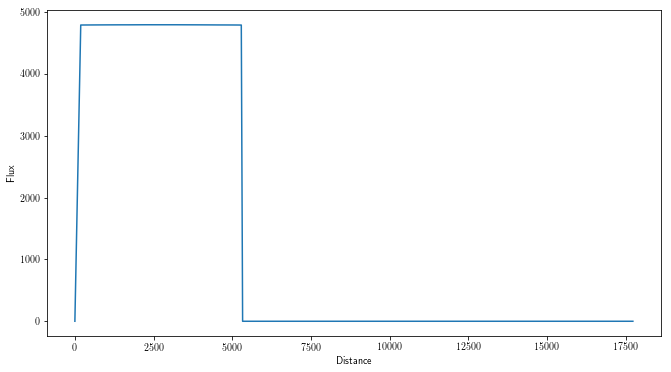

In [166]:
plt.plot(dist,rad(dist))
plt.ylabel('Flux')
plt.xlabel('Distance')

In [120]:
prob2= np.array([F1(flon2[i],flat2[i],f1) if convert(flat2[i],flon2[i],alt)>convert(maxphi,flon2[i],alt) else 0. for i in range(flon2.shape[0])])
dist2=np.array([distance(flon2[i-1],flat2[i-1],flon2[i],flat2[i]) for i in range(1,flon2.shape[0])])
dist2=np.cumsum(np.insert(dist2,0,0))
rad2=interp1d(dist2,prob2)
integrated_rad2=quad(rad2,dist2[0],dist2[-1])

In [123]:
integrated_rad2[0],integrated_rad2

14484361.610510167

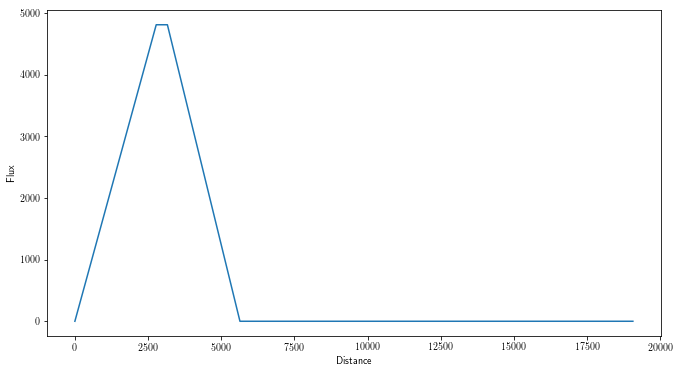

In [121]:
plt.plot(dist2,rad2(dist2))
plt.ylabel('Flux')
plt.xlabel('Distance')

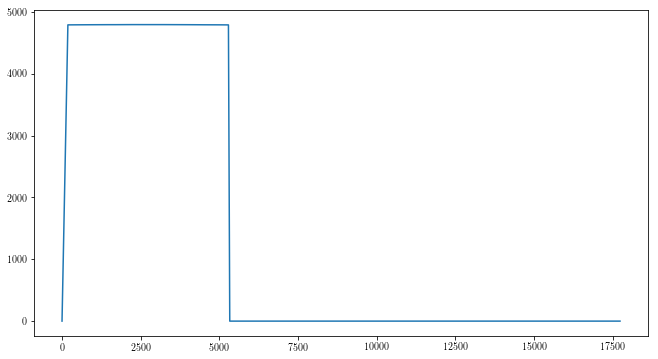

In [119]:
plt.plot(dist,rad(dist))

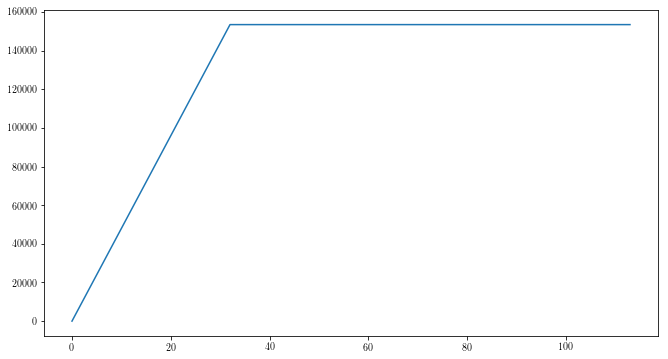

In [292]:
plt.plot(np.cumsum(rad(dist)))

In [34]:
flat[::nn]flat2

array([-24.01838787, -12.        , -20.85584042, -25.83475533,
        -9.49999969,   2.69553983,   3.03284594,   6.19463491, -16.78387625])

In [30]:
Data=np.zeros((dist.shape[0],5))
Data[:,0]=flon
Data[:,2]=flat
Data[:,2]=dist
Data[:,3]=rad(dist)
Data[:,4]=np.cumsum(rad(dist)) 
np.savetxt('Data/data.csv',Data,header='Lon,Lat,Distance,Radiance,CummulativeRadiance',delimiter=',',comments='')

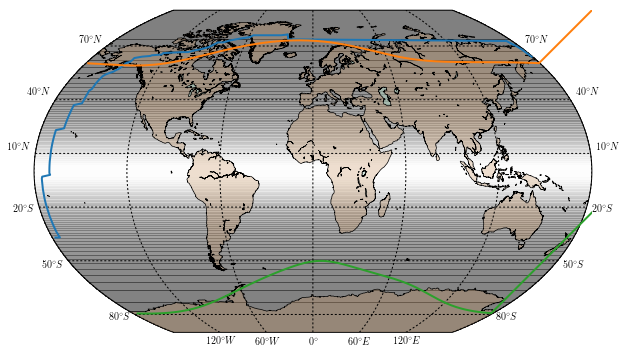

In [59]:
X,Y=np.meshgrid(lons,lats)
plt.figure(figsize=(10,20))
#m = Basemap(projection='ortho',lat_0=20,lon_0=-120,resolution='l')
#m=Basemap(projection='ortho',lon_0=-140,lat_0=15)
         # ,llcrnrlon=min(flon.min()-10,-180), llcrnrlat=min(flat.min()-10,-90), 
         # urcrnrlon=max(flon.max()+10,180), urcrnrlat=max(flat.max()+10,90))
#llcrnrlon=0,llcrnrlat=-90,urcrnrlon=360,urcrnrlat=90,
m=Basemap(projection='kav7',resolution='l',llcrnrlon=-180,llcrnrlat=-90, urcrnrlon=180,urcrnrlat=90,lon_0=0)
m.drawcoastlines(linewidth=0.7)
m.fillcontinents(color='#cc9966',lake_color='#99ffff',alpha=0.3)

#a=m.drawgreatcircle(flon[0],flat[0],flon[-1],flat[-1])
m.drawparallels(np.arange(-80,81,30),labels=[1,1,0,0])
#m.drawparallels([maxphi,-maxphi],labels=[1,1,0,0])
m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])
#m.contourf(X,Y,aurora,latlon=True,cmap='gist_gray_r')
#cm=m.contourf(X,Y,H(X*np.pi/90./2,Y*np.pi/90./2,'tropo'),latlon=True)
#cm=m.imshow(F1(X,Y,f1),cmap='gist_gray_r',alpha=0.5)
M=F1(X,Y,f1)
cm=m.contourf(X,Y,M,latlon=True,alpha=0.5,cmap='gist_gray_r',levels=np.linspace(M.min(),M.max()))
#plt.colorbar(cm)
m.plot(flon,flat,latlon=True,linewidth=2.)
#m.plot(flon2,flat2,latlon=True,linewidth=2.)
m.plot(m.shiftdata(mlonN, mlatN)[0],m.shiftdata(mlonN, mlatN)[1],latlon=True,linewidth=2)
m.plot(m.shiftdata(mlonS, mlatS)[0],m.shiftdata(mlonS, mlatS)[1],latlon=True,linewidth=2)
#m.plot(lons,mN(lons),'.',latlon=True)
#m.plot(mlonN,mN(mlonN),'.',latlon=True)
#m.plot(mlonS,mS(mlonS),'.',latlon=True)

In [154]:
distance(flon[0],flat[0],flon[-1],flat[-1])

16798.137435855489

In [ ]:
def cf(flon,flat,)